In [1]:
import pandas as pd
import numpy as np

cols = ['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
        'fuel', 'odometer', 'transmission', 'drive', 'type', 'state']

chunk_size = 50_000
df_list = []

for chunk in pd.read_csv("vehicles.csv", usecols=cols, chunksize=chunk_size):
    chunk = chunk.dropna(subset=['price', 'year'])      
    chunk = chunk[chunk['price'] > 100]                 
    chunk = chunk[chunk['price'] < 200000]              
    chunk = chunk[chunk['year'] >= 1990]                
    df_list.append(chunk)

df = pd.concat(df_list, ignore_index=True)

print("Shape before further cleaning:", df.shape)
df.head()

cat_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
            'transmission', 'drive', 'type', 'state']

for col in cat_cols:
    df[col] = df[col].fillna('unknown')

df['odometer'] = df['odometer'].fillna(df['odometer'].median())

print("Null values remaining:\n", df.isnull().sum())
df.head()

df.to_csv("used_cars_clean.csv", index=False)
print("Clean dataset saved successfully!")
print("Final shape:", df.shape)


Shape before further cleaning: (377323, 12)
Null values remaining:
 price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
state           0
dtype: int64
Clean dataset saved successfully!
Final shape: (377323, 12)


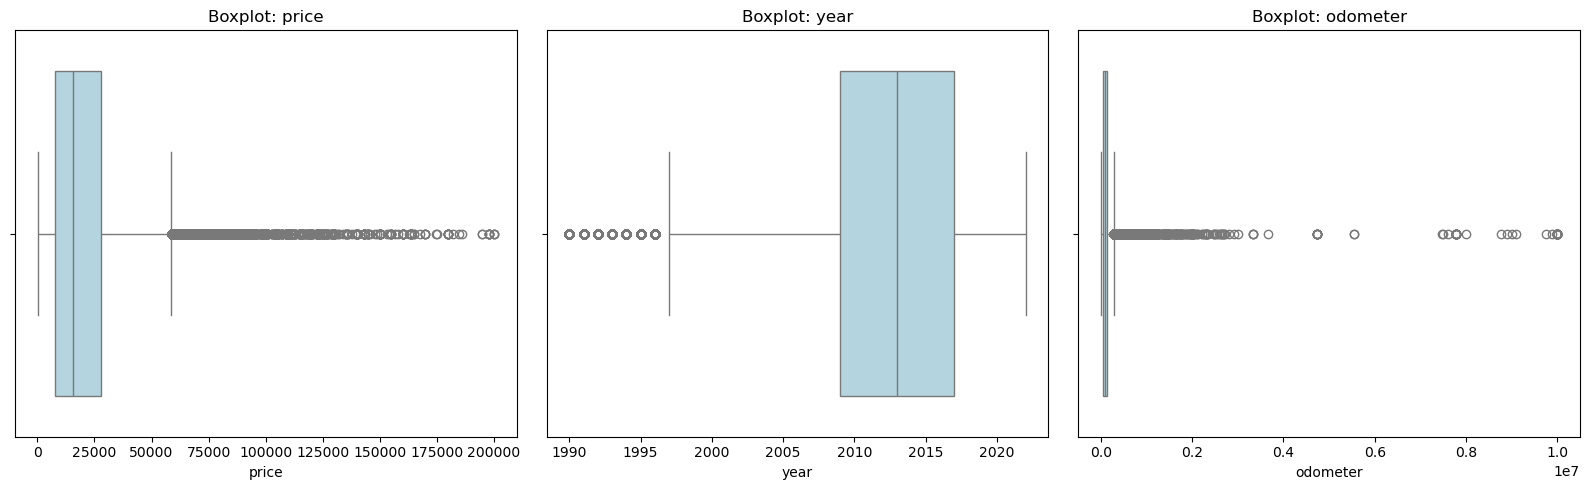

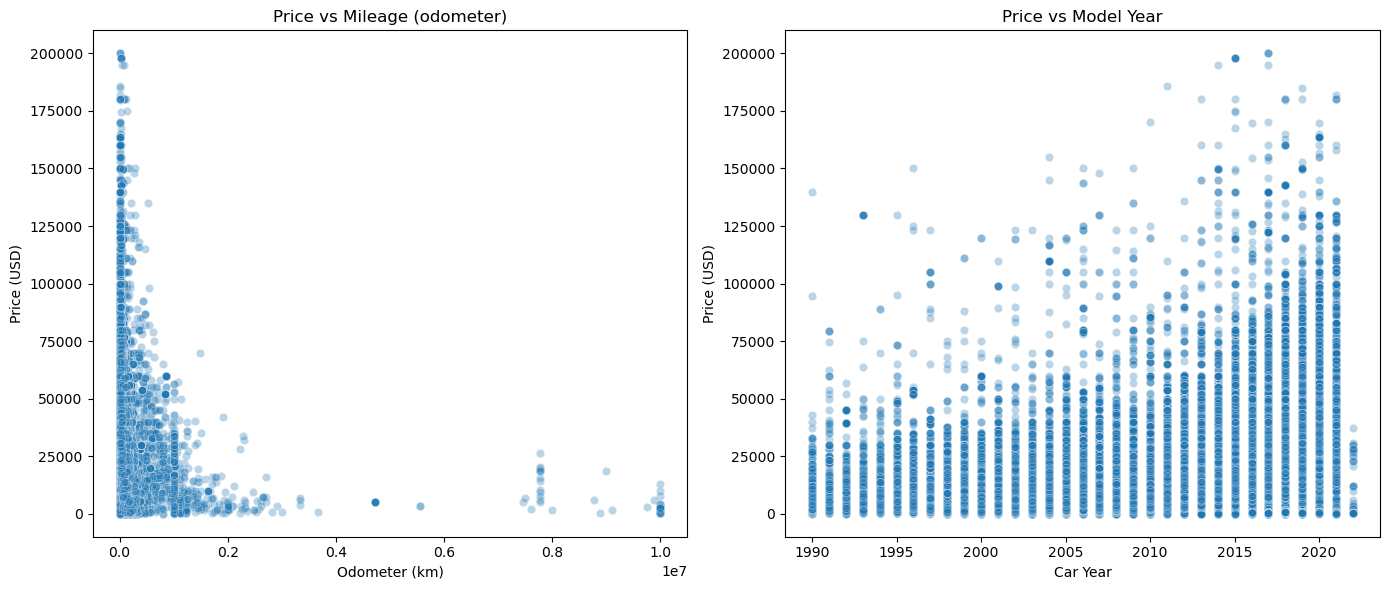

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['price', 'year', 'odometer']

plt.figure(figsize=(16, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='odometer', y='price', alpha=0.3)
plt.title("Price vs Mileage (odometer)")
plt.xlabel("Odometer (km)")
plt.ylabel("Price (USD)")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='year', y='price', alpha=0.3)
plt.title("Price vs Model Year")
plt.xlabel("Car Year")
plt.ylabel("Price (USD)")

plt.tight_layout()
plt.show()

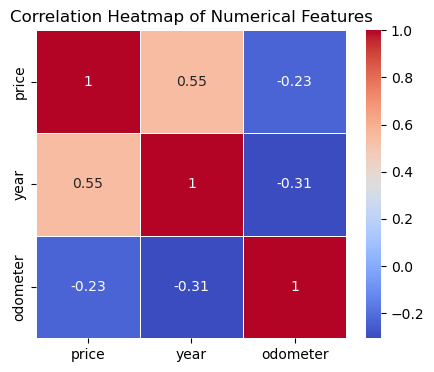

/var/folders/k0/y7t6hckj6z385z07sx9jx_qc0000gn/T/ipykernel_94138/2368060486.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feat_names, palette="viridis")


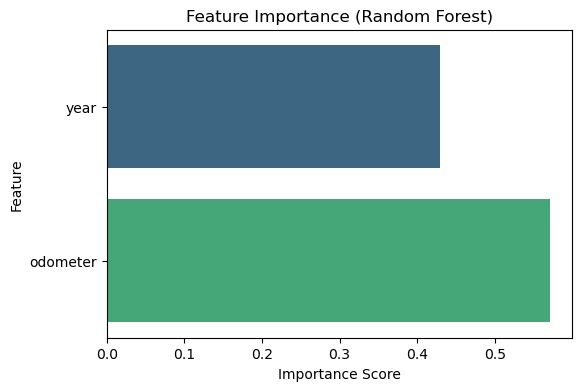

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

numeric_cols = ['price', 'year', 'odometer']
corr = df[numeric_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

X_temp = df[['year', 'odometer']]
y_temp = df['price']

rf_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
rf_model.fit(X_temp, y_temp)

importances = rf_model.feature_importances_
feat_names = ['year', 'odometer']

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feat_names, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [4]:
df = pd.read_csv("used_cars_clean.csv")

def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

df = df.drop(['model'], axis=1)

print("Classes distribution:\n", df['price_category'].value_counts(normalize=True))
df.head()

X = df.drop(['price', 'price_category'], axis=1)  # keep price for regression later
y = df['price_category']

cat_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(exclude=['object']).columns

print("Categorical:", list(cat_columns))
print("Numerical:", list(num_columns))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

X_train_sample = preprocessor.fit_transform(X_train)
X_test_sample = preprocessor.transform(X_test)

print("After encoding:")
print("Train shape:", X_train_sample.shape)
print("Test shape:", X_test_sample.shape)


Classes distribution:
 price_category
midrange    0.442093
budget      0.355115
premium     0.202792
Name: proportion, dtype: float64
Categorical: ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'state']
Numerical: ['year', 'odometer']
Train size: (301858, 10)
Test size: (75465, 10)
After encoding:
Train shape: (301858, 139)
Test shape: (75465, 139)


Original shape: (377323, 12)
   price    year manufacturer                     model  condition  \
0  33590  2014.0          gmc  sierra 1500 crew cab slt       good   
1  22590  2010.0    chevrolet            silverado 1500       good   
2  39590  2020.0    chevrolet       silverado 1500 crew       good   
3  30990  2017.0       toyota      tundra double cab sr       good   
4  15000  2013.0         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer transmission    drive    type state  
0  8 cylinders  gas   57923.0        other  unknown  pickup    al  
1  8 cylinders  gas   71229.0        other  unknown  pickup    al  
2  8 cylinders  gas   19160.0        other  unknown  pickup    al  
3  8 cylinders  gas   41124.0        other  unknown  pickup    al  
4  6 cylinders  gas  128000.0    automatic      rwd   truck    al  

Class distribution (proportion):
price_category
midrange    0.442093
budget      0.355115
premium     0.202792
Name: proportion, dtype: float

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy   : 0.8053
Precision  : 0.8070
Recall     : 0.8003
F1-score   : 0.8034
ROC-AUC    : 0.9342
Log Loss   : 0.4826

===== CLASSIFICATION MODEL COMPARISON =====
                 Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC (OVR)  Log Loss
         Random Forest  0.831829   0.845346 0.819912  0.830680       0.950600  0.482406
                   KNN  0.810932   0.813982 0.807773  0.810739       0.928046  1.519782
    MLP Neural Network  0.805340   0.806972 0.800303  0.803419       0.934218  0.482567
         Decision Tree  0.793586   0.806075 0.777174  0.788966       0.918114  0.731178
Support Vector Machine  0.776519   0.774210 0.771972  0.773054            NaN       NaN
   Logistic Regression  0.775684   0.778420 0.766114  0.771700       0.910817  0.560105
     Gradient Boosting  0.767429   0.769430 0.755535  0.761745       0.909502  0.560820
           Naive Bayes  0.393692   0.523247 0.467195  0.368009       0.725350 13.387633


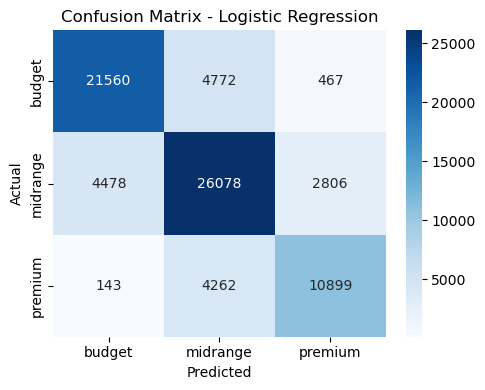

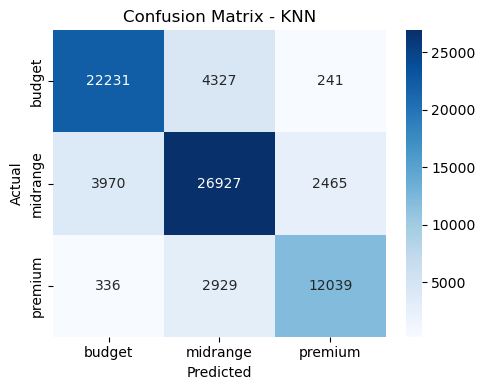

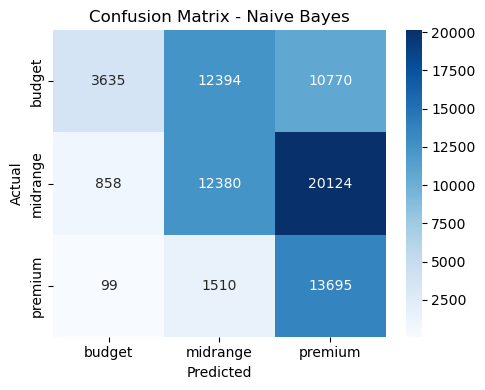

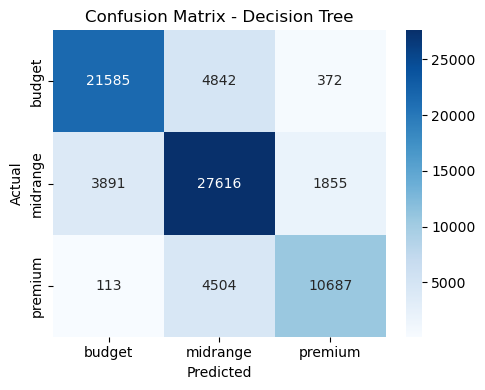

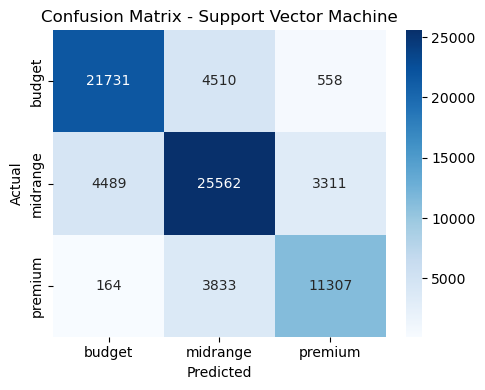

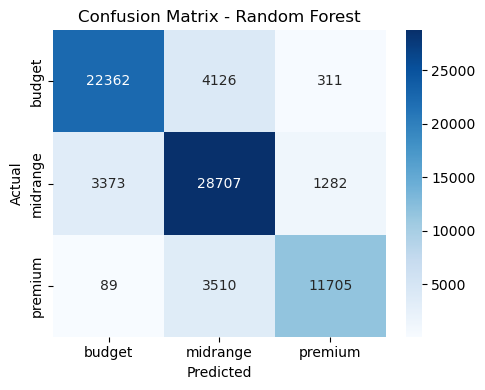

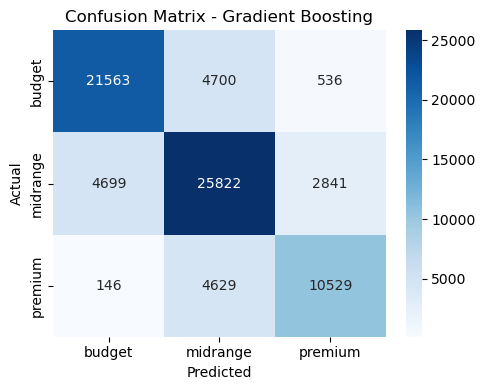

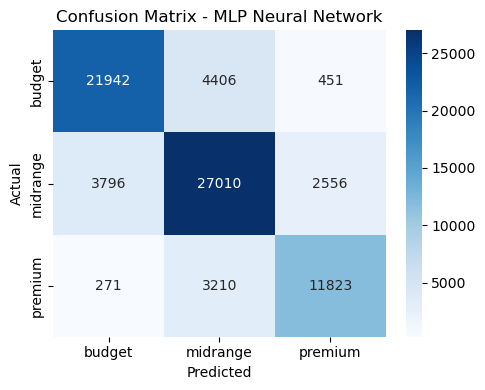

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_auc_score, log_loss)
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("used_cars_clean.csv")

print("Original shape:", df.shape)
print(df.head())

def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

print("\nClass distribution (proportion):")
print(df['price_category'].value_counts(normalize=True))

if 'model' in df.columns:
    df = df.drop(columns=['model'])

X = df.drop(columns=['price', 'price_category'])
y = df['price_category']

print("\nFeature columns:")
print(X.columns)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numerical columns:", num_cols)

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print("\nShape after one-hot encoding:", X_encoded.shape)

scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nFull Train shape:", X_train_full.shape)
print("Test shape      :", X_test.shape)

sample_all = 150000
sample_heavy = 20000   

if len(X_train_full) > sample_all:
    X_train_all = X_train_full.sample(n=sample_all, random_state=42)
    y_train_all = y_train_full.loc[X_train_all.index]
else:
    X_train_all = X_train_full
    y_train_all = y_train_full

if len(X_train_all) > sample_heavy:
    X_train_heavy = X_train_all.sample(n=sample_heavy, random_state=42)
    y_train_heavy = y_train_all.loc[X_train_heavy.index]
else:
    X_train_heavy = X_train_all
    y_train_heavy = y_train_all

print("\nTrain subset for normal models:", X_train_all.shape)
print("Train subset for heavy models :", X_train_heavy.shape)

models = {
    "Logistic Regression": LogisticRegression(max_iter=200, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=12, random_state=42),

    "Support Vector Machine": SVC(
        kernel='linear',     
        probability=False,    
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=120,
        max_depth=18,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=60,
        random_state=42
    ),
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(64,),
        max_iter=80,
        random_state=42
    )
}

heavy_models = ["Gradient Boosting", "MLP Neural Network", "Support Vector Machine"]

results = []
conf_matrices = {}
class_names = ['budget', 'midrange', 'premium']

for name, model in models.items():
    print(f"\n==============================")
    print(f"Training model: {name}")
    print(f"==============================")
    
    if name in heavy_models:
        X_fit = X_train_heavy
        y_fit = y_train_heavy
    else:
        X_fit = X_train_all
        y_fit = y_train_all
    
    model.fit(X_fit, y_fit)
    
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    if y_prob is not None:
        ll = log_loss(y_test, y_prob)
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        except Exception as e:
            print("Could not compute ROC-AUC:", e)
            roc_auc = np.nan
    else:
        ll = np.nan
        roc_auc = np.nan
    
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1-score   : {f1:.4f}")
    print(f"ROC-AUC    : {roc_auc:.4f}")
    print(f"Log Loss   : {ll:.4f}")
    
    results.append([
        name, acc, prec, rec, f1, roc_auc, ll
    ])
    
    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    conf_matrices[name] = cm

results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall",
    "F1 Score", "ROC-AUC (OVR)", "Log Loss"
])

results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\n===== CLASSIFICATION MODEL COMPARISON =====")
print(results_df.to_string(index=False))

for name, cm in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues"
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


Full data shape: (377323, 12)
Sampled data shape: (10000, 12)
Encoded sample shape: (10000, 129)
PCA-transformed shape: (10000, 2)
Explained Variance by 2 PCs: 0.044118532934355734


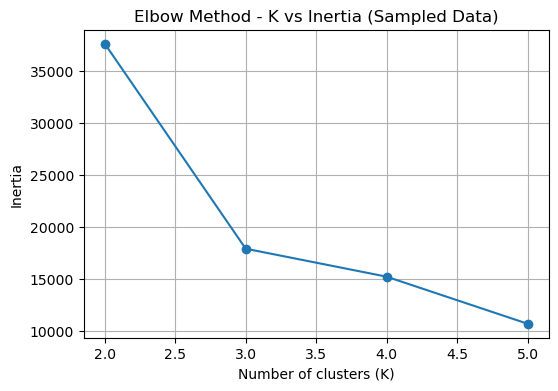

Silhouette Score for K=3 (sampled data): 0.4587


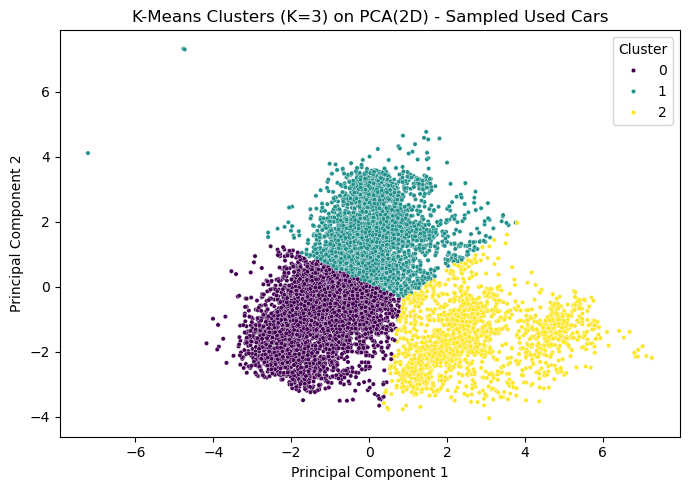

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("used_cars_clean.csv")

def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

if 'model' in df.columns:
    df = df.drop(columns=['model'])

print("Full data shape:", df.shape)

sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)
print("Sampled data shape:", df_sample.shape)

X_sample = df_sample.drop(columns=['price', 'price_category'])

X_sample_encoded = pd.get_dummies(X_sample, drop_first=True)
print("Encoded sample shape:", X_sample_encoded.shape)

scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample_encoded)

pca = PCA(n_components=2)
X_sample_pca = pca.fit_transform(X_sample_scaled)

print("PCA-transformed shape:", X_sample_pca.shape)
print("Explained Variance by 2 PCs:", pca.explained_variance_ratio_.sum())

inertia_list = []
K_range = range(2, 6)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample_pca)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia_list, marker='o')
plt.title("Elbow Method - K vs Inertia (Sampled Data)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
sample_clusters = kmeans_final.fit_predict(X_sample_pca)

df_sample['cluster'] = sample_clusters

sil_score = silhouette_score(X_sample_pca, sample_clusters)
print(f"Silhouette Score for K={optimal_k} (sampled data): {sil_score:.4f}")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_sample_pca[:, 0],
    y=X_sample_pca[:, 1],
    hue=df_sample['cluster'],
    palette='viridis',
    s=10
)
plt.title("K-Means Clusters (K=3) on PCA(2D) - Sampled Used Cars")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Hierarchical clustering sample shape: (1000, 123)


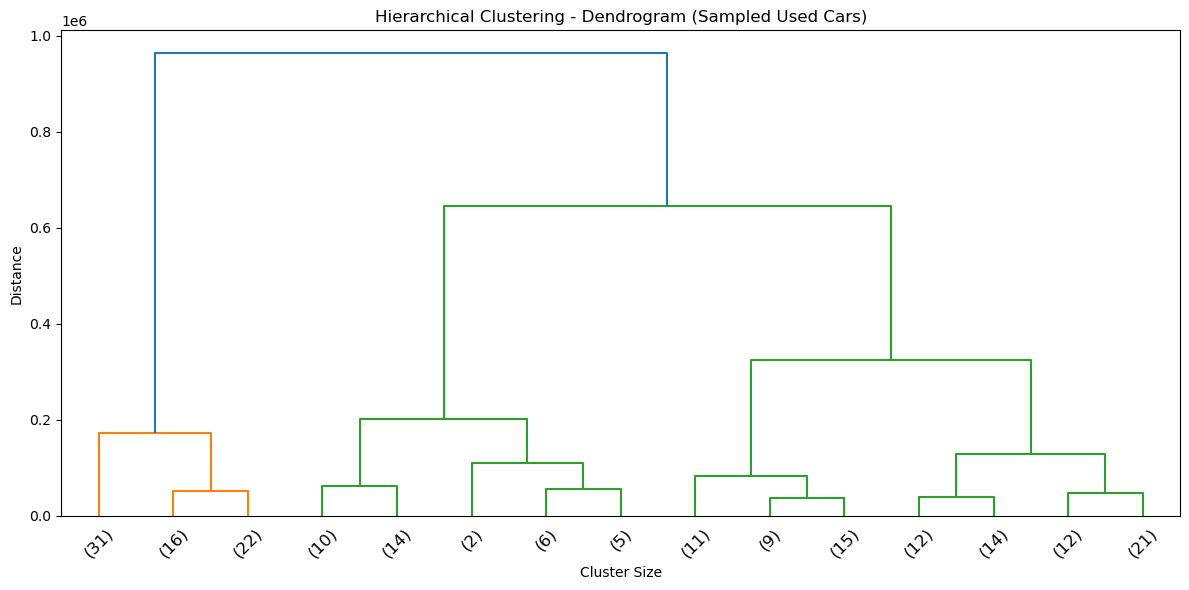

In [7]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

sample_size = 1000
df_hier = df.sample(n=sample_size, random_state=42)
X_hier = df_hier.drop(columns=['price', 'price_category'], errors='ignore')
X_hier_enc = pd.get_dummies(X_hier, drop_first=True)

print("Hierarchical clustering sample shape:", X_hier_enc.shape)

linkage_matrix = linkage(X_hier_enc.iloc[:200], method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix,
           truncate_mode='lastp',  
           p=15,                   
           leaf_rotation=45)
plt.title("Hierarchical Clustering - Dendrogram (Sampled Used Cars)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


Original shape: (377323, 12)
   price    year manufacturer                     model  condition  \
0  33590  2014.0          gmc  sierra 1500 crew cab slt       good   
1  22590  2010.0    chevrolet            silverado 1500       good   
2  39590  2020.0    chevrolet       silverado 1500 crew       good   
3  30990  2017.0       toyota      tundra double cab sr       good   
4  15000  2013.0         ford                 f-150 xlt  excellent   

     cylinders fuel  odometer transmission    drive    type state  
0  8 cylinders  gas   57923.0        other  unknown  pickup    al  
1  8 cylinders  gas   71229.0        other  unknown  pickup    al  
2  8 cylinders  gas   19160.0        other  unknown  pickup    al  
3  8 cylinders  gas   41124.0        other  unknown  pickup    al  
4  6 cylinders  gas  128000.0    automatic      rwd   truck    al  

Regression feature columns:
Index(['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'drive', 'typ

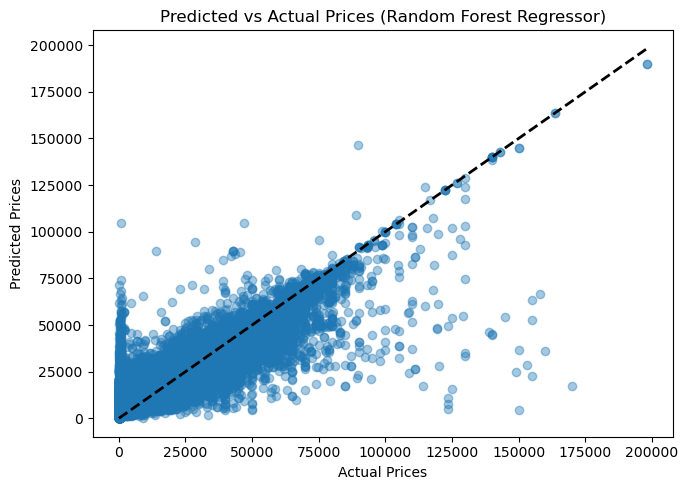


Training Regression Model: Gradient Boosting Regressor
MAE  : 5251.91
MSE  : 73912338.71
RMSE : 8597.23
R^2  : 0.6663

===== REGRESSION MODEL COMPARISON =====
                      Model         MAE          MSE        RMSE  R^2 Score
    Random Forest Regressor 3324.829029 3.842770e+07 6199.007985   0.826531
Gradient Boosting Regressor 5251.914473 7.391234e+07 8597.228548   0.666347
          Linear Regression 6314.891286 9.269326e+07 9627.733732   0.581567


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv("used_cars_clean.csv")

print("Original shape:", df.shape)
print(df.head())


def categorize_price(price):
    if price <= 10000:
        return 'budget'
    elif price <= 30000:
        return 'midrange'
    else:
        return 'premium'

df['price_category'] = df['price'].apply(categorize_price)

if 'model' in df.columns:
    df = df.drop(columns=['model'])


X_reg = df.drop(columns=['price', 'price_category'])
y_reg = df['price']

print("\nRegression feature columns:")
print(X_reg.columns)

cat_cols = X_reg.select_dtypes(include=['object']).columns.tolist()
num_cols = X_reg.select_dtypes(exclude=['object']).columns.tolist()

print("\nCategorical columns:", cat_cols)
print("Numerical columns:", num_cols)

X_reg_encoded = pd.get_dummies(X_reg, columns=cat_cols, drop_first=True)

print("\nShape after encoding (Regression):", X_reg_encoded.shape)

scaler = StandardScaler()
X_reg_encoded[num_cols] = scaler.fit_transform(X_reg_encoded[num_cols])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg,
    test_size=0.2,
    random_state=42
)

print("\nRegression Train shape:", X_train_reg.shape)
print("Regression Test shape :", X_test_reg.shape)

reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=150, max_depth=20, random_state=42, n_jobs=-1
    ),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        random_state=42
    )
}

reg_results = []

for name, model in reg_models.items():
    print(f"\n==============================")
    print(f"Training Regression Model: {name}")
    print(f"==============================")
    
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred_reg)
    
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R^2  : {r2:.4f}")

    if name == "Random Forest Regressor":
        plt.figure(figsize=(7,5))
        plt.scatter(y_test_reg, y_pred_reg, alpha=0.4)
        plt.plot([y_test_reg.min(), y_test_reg.max()],
                 [y_test_reg.min(), y_test_reg.max()],
                 'k--', linewidth=2)
        plt.xlabel("Actual Prices")
        plt.ylabel("Predicted Prices")
        plt.title("Predicted vs Actual Prices (Random Forest Regressor)")
        plt.tight_layout()
        plt.show()

    
    reg_results.append([name, mae, mse, rmse, r2])

reg_results_df = pd.DataFrame(reg_results, columns=[
    "Model", "MAE", "MSE", "RMSE", "R^2 Score"
])

reg_results_df = reg_results_df.sort_values(by="RMSE")
print("\n===== REGRESSION MODEL COMPARISON =====")
print(reg_results_df.to_string(index=False))


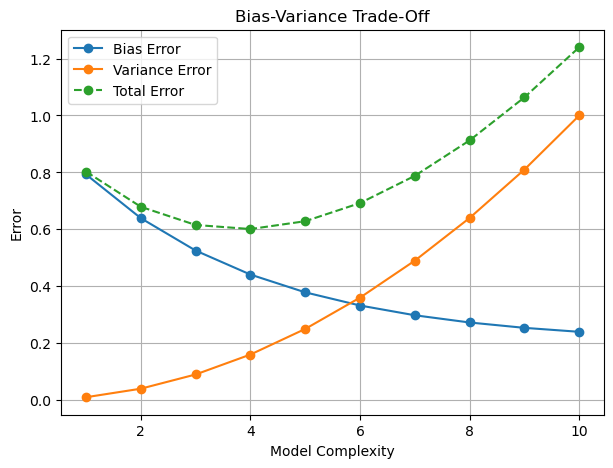

Bias decreases with more complex models,
Variance increases with more complex models,
Optimal model lies where total error is minimum.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

model_complexity = np.linspace(1, 10, 10)
bias_error = np.exp(-0.3 * model_complexity) * 0.8 + 0.2
variance_error = (model_complexity / 10) ** 2
total_error = bias_error + variance_error

plt.figure(figsize=(7,5))
plt.plot(model_complexity, bias_error, marker='o', label="Bias Error")
plt.plot(model_complexity, variance_error, marker='o', label="Variance Error")
plt.plot(model_complexity, total_error, marker='o', label="Total Error", linestyle='--')

plt.title("Bias-Variance Trade-Off")
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

print("Bias decreases with more complex models,")
print("Variance increases with more complex models,")
print("Optimal model lies where total error is minimum.")


/var/folders/k0/y7t6hckj6z385z07sx9jx_qc0000gn/T/ipykernel_94138/3915817132.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


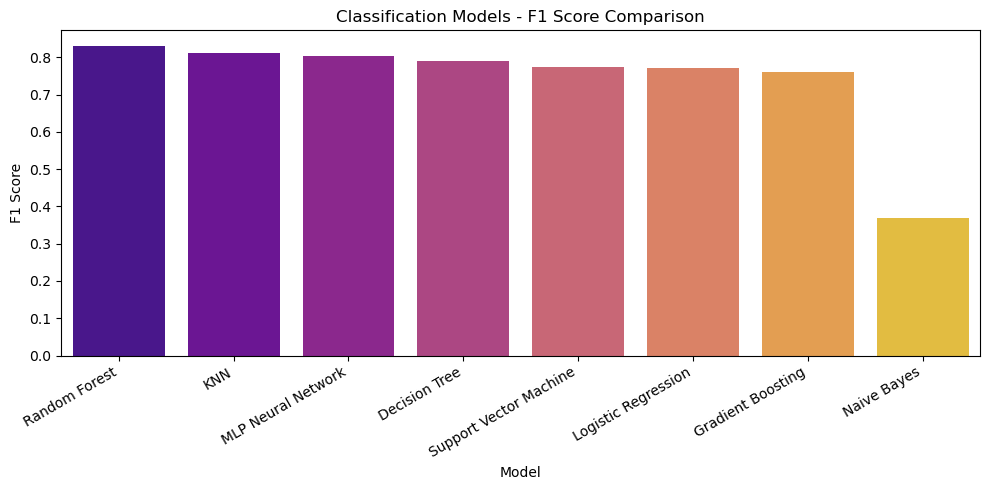

/var/folders/k0/y7t6hckj6z385z07sx9jx_qc0000gn/T/ipykernel_94138/3915817132.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


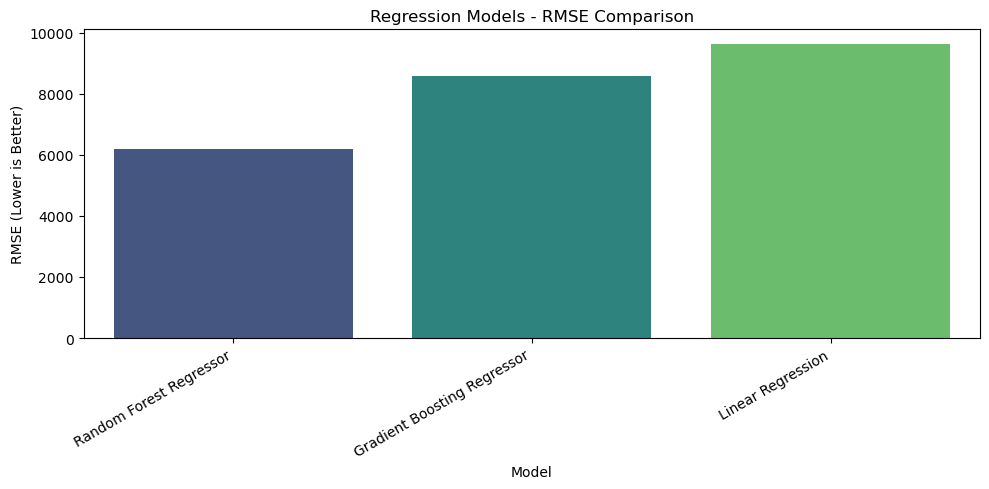

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    x=results_df['Model'], 
    y=results_df['F1 Score'],
    palette="plasma"
)
plt.title("Classification Models - F1 Score Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(
    x=reg_results_df['Model'], 
    y=reg_results_df['RMSE'],
    palette="viridis"
)
plt.title("Regression Models - RMSE Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.show()